In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas
!pip install transformers sklearn
!pip install transformers datasets scikit-learn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
# Load the necessary files into pandas DataFrames
dev_data = pd.read_csv('/content/drive/MyDrive/MentalQA/data/sub_task1/dev_data.tsv', sep='\t')
dev_label = pd.read_csv('/content/drive/MyDrive/MentalQA/data/sub_task1/dev_label.tsv', sep='\t')

# Rename columns for consistency if not already named correctly
dev_data.columns = ['Question']       # or use: dev_data.rename(columns={'question': 'Question'}, inplace=True)
dev_label.columns = ['Labels']        # or use: dev_label.rename(columns={'labels': 'Labels'}, inplace=True)

# Merge the two DataFrames on index
questions_labels_df = pd.merge(dev_data, dev_label, left_index=True, right_index=True)

# Display preview
display(questions_labels_df.head())


,Question,Labels
0,من سنه تقريبا و انا أذي نفسي ب اكثر من طريقة و...,"B, E"
1,السلام عليكم مشكلتي تقتصر على تكرار كلمة معينة...,"A, E"
2,اكتئاب وفوبيا من المجتمع وانعزال وانطوائية وتع...,"B, D"
3,هل الإحساس بقرب الاجل و الخوف من الموت و الاحل...,"A, B, D"
4,اهلا يا طبيب ، انا اعاني من عدة أعراض لمدة اسب...,"A, F"


In [ ]:
# Cell 3: Label Mapping and Data Integrity Checks

# (Redundant) Column rename (already handled above, kept here for robustness)
dev_data.columns = ['Question']
dev_label.columns = ['Labels']

# Merge again just to ensure this cell can run independently if needed
questions_labels_df = pd.merge(dev_data, dev_label, left_index=True, right_index=True)

# Label mapping dictionary
label_mapping = {
    'A': 'Diagnosis',
    'B': 'Treatment',
    'C': 'Anatomy and Physiology',
    'D': 'Epidemiology',
    'E': 'Healthy Lifestyle',
    'F': 'Provider Choices',
    'Z': 'Other'
}

# Function to convert label codes to readable labels
def map_labels(label_str):
    labels = label_str.split(', ')
    return ', '.join([label_mapping.get(label, label) for label in labels])

# Apply the function
questions_labels_df['True_Labels'] = questions_labels_df['Labels'].apply(map_labels)

# Preview updated DataFrame
display(questions_labels_df.head())

# Basic data checks
print("Null Questions               :", questions_labels_df['Question'].isnull().sum())
print("Empty Questions              :", (questions_labels_df['Question'].str.strip() == '').sum())
print("Null Labels                  :", questions_labels_df['Labels'].isnull().sum())
print("Empty Labels                 :", (questions_labels_df['Labels'].str.strip() == '').sum())
print("Duplicate rows               :", questions_labels_df.duplicated().sum())
print("Duplicate Questions          :", questions_labels_df['Question'].duplicated().sum())
print("Duplicate Question+Label pairs:", questions_labels_df.duplicated(subset=['Question', 'Labels']).sum())


,Question,Labels,True_Labels
0,من سنه تقريبا و انا أذي نفسي ب اكثر من طريقة و...,"B, E","Treatment, Healthy Lifestyle"
1,السلام عليكم مشكلتي تقتصر على تكرار كلمة معينة...,"A, E","Diagnosis, Healthy Lifestyle"
2,اكتئاب وفوبيا من المجتمع وانعزال وانطوائية وتع...,"B, D","Treatment, Epidemiology"
3,هل الإحساس بقرب الاجل و الخوف من الموت و الاحل...,"A, B, D","Diagnosis, Treatment, Epidemiology"
4,اهلا يا طبيب ، انا اعاني من عدة أعراض لمدة اسب...,"A, F","Diagnosis, Provider Choices"


Null Questions               : 0
Empty Questions              : 0
Null Labels                  : 0
Empty Labels                 : 0
Duplicate rows               : 0
Duplicate Questions          : 0
Duplicate Question+Label pairs: 0


Label count distribution per question:
NumLabels
1    151
2    142
3     52
4      4
Name: count, dtype: int64


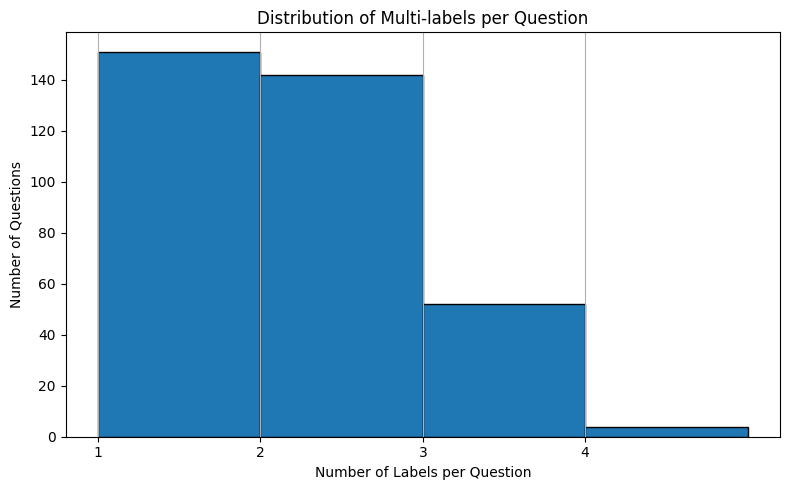

In [ ]:
# Cell 4: Multi-label Analysis

# Convert string label to list format
questions_labels_df['LabelList'] = questions_labels_df['Labels'].apply(lambda x: x.split(', '))

# Count how many labels each question has
questions_labels_df['NumLabels'] = questions_labels_df['LabelList'].apply(len)

# Show distribution of label counts
print("Label count distribution per question:")
print(questions_labels_df['NumLabels'].value_counts().sort_index())

# Visualize distribution with a histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
questions_labels_df['NumLabels'].hist(bins=range(1, questions_labels_df['NumLabels'].max() + 2), edgecolor='black')
plt.xlabel("Number of Labels per Question")
plt.ylabel("Number of Questions")
plt.title("Distribution of Multi-labels per Question")
plt.xticks(range(1, questions_labels_df['NumLabels'].max() + 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


🔢 Label Frequencies:
Label 'A': 196
Label 'B': 203
Label 'C': 22
Label 'D': 79
Label 'E': 87
Label 'F': 14
Label 'Z': 6


/tmp/ipython-input-26-3746442861.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


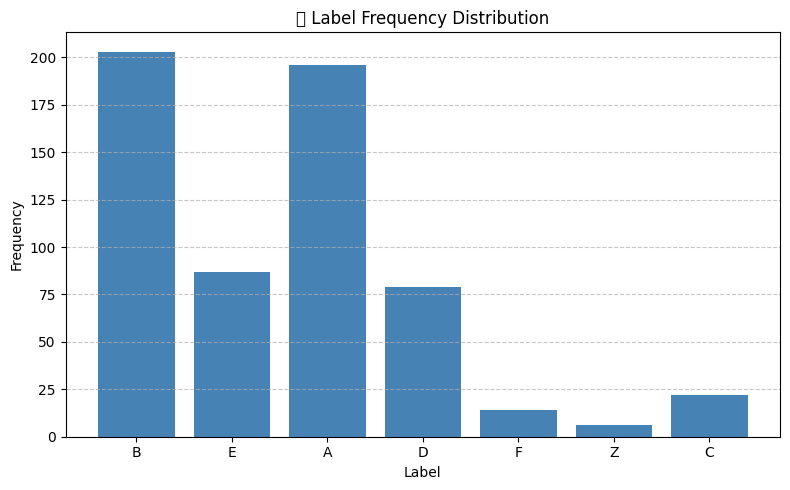

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Make sure LabelList column exists
questions_labels_df['LabelList'] = questions_labels_df['Labels'].apply(
    lambda x: x.split(', ') if isinstance(x, str) else []
)

# Flatten the list of lists into a single list of labels
all_labels = [label for sublist in questions_labels_df['LabelList'] for label in sublist]

# Count frequency of each label
label_freq = Counter(all_labels)

# Print label frequencies sorted alphabetically
print("🔢 Label Frequencies:")
for label, count in sorted(label_freq.items()):
    print(f"Label '{label}': {count}")

# Plot label distribution
plt.figure(figsize=(8, 5))
plt.bar(label_freq.keys(), label_freq.values(), color='steelblue')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("📊 Label Frequency Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter
import numpy as np

# Define your target counts per label
min_samples = {
    'F': 100,
    'Z': 100,
    'C': 100  # Optional
}

def oversample_specific_classes(df, min_samples):
    df = df.copy()
    df['LabelList'] = df['Labels'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

    # Get initial label counts
    label_counts = Counter([label for sub in df['LabelList'] for label in sub])

    augmented_rows = []

    for label, target_count in min_samples.items():
        current_count = label_counts[label]
        if current_count >= target_count:
            continue  # already enough

        # Get all rows that contain this label
        matching_rows = df[df['LabelList'].apply(lambda x: label in x)]

        # Repeat these rows as needed
        num_needed = target_count - current_count
        reps = int(np.ceil(num_needed / len(matching_rows)))
        duplicated = pd.concat([matching_rows] * reps, ignore_index=True).iloc[:num_needed]

        augmented_rows.append(duplicated)

    # Combine original + oversampled
    df_augmented = pd.concat([df] + augmented_rows, ignore_index=True)

    return df_augmented

# Add this before splitting train/val/test
questions_labels_df['LabelList'] = questions_labels_df['Labels'].apply(lambda x: x.split(', '))

augmented_df = oversample_specific_classes(questions_labels_df, min_samples)
# Ensure LabelList is always a list, even if the row is empty or NaN
questions_labels_df['LabelList'] = questions_labels_df['Labels'].apply(
    lambda x: x.split(', ') if isinstance(x, str) else []
)


augmented_df['LabelList'] = augmented_df['Labels'].apply(
    lambda x: x.split(', ') if isinstance(x, str) else []
)

# Optional check
from collections import Counter
all_labels = [l for sub in augmented_df['LabelList'] for l in sub]
print("Label counts after oversampling:", Counter(all_labels))


Label counts after oversampling: Counter({'A': 359, 'B': 305, 'D': 183, 'E': 127, 'F': 100, 'Z': 100, 'C': 100})


In [ ]:
from sklearn.model_selection import train_test_split

# Split into 70% train and 30% temp (val+test)
train_df, temp_df = train_test_split(questions_labels_df, test_size=0.3, random_state=42)

# Then split temp into 15% val and 15% test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Show the resulting split sizes
print(f"✅ Training data size: {len(train_df)}")
print(f"✅ Test data size: {len(test_df)}")


✅ Training data size: 244
✅ Test data size: 53


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

train_labels = train_df['Labels'].apply(lambda x: x.split(', '))
val_labels = val_df['Labels'].apply(lambda x: x.split(', '))
test_labels = test_df['Labels'].apply(lambda x: x.split(', '))

y_train = mlb.fit_transform(train_labels)
y_val = mlb.transform(val_labels)
y_test = mlb.transform(test_labels)


In [ ]:
from transformers import AutoTokenizer

# ✅ Load MARBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('UBC-NLP/MARBERT')

# ✅ Tokenize the training and testing questions
train_encodings = tokenizer(list(train_df['Question']), padding=True, truncation=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(list(val_df['Question']), padding=True, truncation=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(test_df['Question']), padding=True, truncation=True, max_length=512, return_tensors='pt')




In [ ]:
from datasets import Dataset
import torch

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': torch.tensor(y_train, dtype=torch.float32)
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': torch.tensor(y_val, dtype=torch.float32)
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': torch.tensor(y_test, dtype=torch.float32)
})


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Optional: Helps debug CUDA errors

from transformers import AutoModelForSequenceClassification

# 🔹 Load the MARBERT model for multi-label classification
model = AutoModelForSequenceClassification.from_pretrained(
    'UBC-NLP/MARBERT',
    num_labels=len(mlb.classes_),                    # Number of output labels
    problem_type="multi_label_classification"        # Informs the model to use sigmoid + BCEWithLogitsLoss
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from torch.nn import Module
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# ---- Custom Focal Loss ----
class FocalLoss(Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ---- Custom Trainer using FocalLoss ----
class FocalLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = FocalLoss(alpha=1.0, gamma=2.0)
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

# ---- Metrics ----
def compute_metrics(pred):
    logits, labels = pred
    probs = torch.sigmoid(torch.tensor(logits))
    preds = (probs > 0.2).int().numpy()  # lower threshold for imbalance
    labels = labels.astype(int)

    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='micro', zero_division=0),
        'recall': recall_score(labels, preds, average='micro', zero_division=0),
        'f1': f1_score(labels, preds, average='micro', zero_division=0),
    }

# ---- Training Args ----
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # increased from 5 to 10
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
)

# ---- Trainer Init ----
trainer = FocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


# ---- Train ----
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.184300,0.157842,0.000000,0.244505,1.000000,0.392936
2,0.131800,0.118008,0.000000,0.244505,1.000000,0.392936
3,0.115200,0.102866,0.000000,0.270517,1.000000,0.425837
4,0.100700,0.101922,0.000000,0.293919,0.977528,0.451948
5,0.087500,0.102522,0.000000,0.294521,0.966292,0.451444
6,0.069100,0.106746,0.000000,0.299663,1.000000,0.461140
7,0.047600,0.112403,0.000000,0.360169,0.955056,0.523077


TrainOutput(global_step=112, training_loss=0.10428432867463146, metrics={'train_runtime': 271.3698, 'train_samples_per_second': 8.991, 'train_steps_per_second': 0.59, 'total_flos': 75487483822800.0, 'train_loss': 0.10428432867463146, 'epoch': 7.0})

In [ ]:
from sklearn.metrics import classification_report
# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)
import numpy as np
from sklearn.metrics import f1_score

# Get sigmoid probabilities
probs = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()

# Store best thresholds per label
best_thresh = {}

# Tune for each label separately
for i, label in enumerate(mlb.classes_):
    best_f1 = 0
    best_t = 0.0
    for t in np.arange(0.1, 0.6, 0.05):  # You can try up to 0.9 if needed
        preds = (probs[:, i] > t).astype(int)
        f1 = f1_score(y_test[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresh[label] = best_t

# Show the result
print("✅ Best threshold per label:")
for label, t in best_thresh.items():
    print(f"{label}: {t:.2f}")

# Create a binary matrix using best thresholds
final_preds = np.zeros_like(probs, dtype=int)

for i, label in enumerate(mlb.classes_):
    threshold = best_thresh[label]
    final_preds[:, i] = (probs[:, i] > threshold).astype(int)
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

# Print classification report with tuned thresholds
print(classification_report(y_test, final_preds, target_names=mlb.classes_))

# Print micro F1 and others
print("🔍 Micro F1 Score:", f1_score(y_test, final_preds, average='micro'))
print("🔍 Macro F1 Score:", f1_score(y_test, final_preds, average='macro'))
print("🔍 Samples F1 Score:", f1_score(y_test, final_preds, average='samples'))


✅ Best threshold per label:
A: 0.40
B: 0.45
C: 0.25
D: 0.35
E: 0.35
F: 0.25
Z: 0.10
              precision    recall  f1-score   support

           A       0.55      0.92      0.69        26
           B       0.65      1.00      0.79        33
           C       0.07      1.00      0.12         3
           D       0.20      0.90      0.33        10
           E       0.38      0.62      0.47        13
           F       0.33      0.33      0.33         3
           Z       0.06      1.00      0.11         3

   micro avg       0.31      0.89      0.46        91
   macro avg       0.32      0.82      0.41        91
weighted avg       0.48      0.89      0.60        91
 samples avg       0.31      0.93      0.45        91

🔍 Micro F1 Score: 0.45892351274787535
🔍 Macro F1 Score: 0.40546790144629286
🔍 Samples F1 Score: 0.44836777478286916


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision, recall, and F1 score (average='micro' for multi-label)
precision = precision_score(y_test, predicted_labels, average='micro')
recall = recall_score(y_test, predicted_labels, average='micro')
f1 = f1_score(y_test, predicted_labels, average='micro')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.2453
Precision: 0.6094
Recall: 0.4286
F1 Score: 0.5032


In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, predicted_labels, target_names=mlb.classes_)

# Print the report
print(report)


              precision    recall  f1-score   support

           A       0.50      0.42      0.46        26
           B       0.66      0.82      0.73        33
           C       0.00      0.00      0.00         3
           D       0.00      0.00      0.00        10
           E       1.00      0.08      0.14        13
           F       0.00      0.00      0.00         3
           Z       0.00      0.00      0.00         3

   micro avg       0.61      0.43      0.50        91
   macro avg       0.31      0.19      0.19        91
weighted avg       0.52      0.43      0.42        91
 samples avg       0.58      0.49      0.50        91



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
